## POS tagging using modified Viterbi

### Data Preparation

In [10]:
#Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

nltk.download('universal_tagset')

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\U6083443\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


True

In [11]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [12]:
# first few tagged sentences
print(nltk_data[:40])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [15]:
# Splitting into train and test
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(f'Length of Training Set: {len(train_set)}')
print(f'Length of Test Set: {len(test_set)}')
print(train_set[:40])

Length of Training Set: 3718
Length of Test Set: 196
[[('If', 'ADP'), ('the', 'DET'), ('money', 'NOUN'), ('manager', 'NOUN'), ('performing', 'VERB'), ('this', 'DET'), ('service', 'NOUN'), ('is', 'VERB'), ('being', 'VERB'), ('paid', 'VERB'), ('by', 'ADP'), ('his', 'PRON'), ('clients', 'NOUN'), ('*-78', 'X'), ('to', 'PRT'), ('match', 'VERB'), ('or', 'CONJ'), ('beat', 'VERB'), ('the', 'DET'), ('return', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('S&P', 'NOUN'), ('500', 'NUM'), ('index', 'NOUN'), (',', '.'), ('he', 'PRON'), ('is', 'VERB'), ('likely', 'ADJ'), ('*-1', 'X'), ('to', 'PRT'), ('remain', 'VERB'), ('fully', 'ADV'), ('invested', 'VERB'), ('at', 'ADP'), ('all', 'DET'), ('times', 'NOUN'), ('.', '.')], [('Among', 'ADP'), ('other', 'ADJ'), ('banking', 'NOUN'), ('issues', 'NOUN'), (',', '.'), ('Pennview', 'NOUN'), ('Savings', 'NOUN'), ('Association', 'NOUN'), ('leapt', 'VERB'), ('more', 'ADJ'), ('than', 'ADP'), ('44', 'NUM'), ('%', 'NOUN'), ('with', 'ADP'), ('a', 'DET'), ('gain', 'NOUN'),

In [20]:
 train_tagged_words = [tup for sent in train_set for tup in sent]

In [21]:
len(train_tagged_words)

95539

In [23]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]

['If',
 'the',
 'money',
 'manager',
 'performing',
 'this',
 'service',
 'is',
 'being',
 'paid']

In [30]:
# vocabulary
V = set(tokens)
print(f'Total Words in Vocabulary: {len(V)}')

Total Words in Vocabulary: 12064


In [31]:
# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(f'Total Tags : {len(T)}')

Total Tags : 12


### Build the vanilla Viterbi based POS tagger

#### Emission Probabilities

In [33]:
# computing P(w/t) and storing in T x V matrix
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [35]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [41]:
print(word_given_tag('Japanese','ADJ'))
print(word_given_tag('Minister','NOUN'))

# book
print("\n", "book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'))

(74, 6069)
(4, 27348)

 book
(6, 27348)
(0, 12852)


In [42]:
def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [44]:
print(t2_given_t1(t2='NOUN', t1='ADJ'))
print(t2_given_t1(t2='NOUN', t1='VERB'))
print(t2_given_t1(t2='PRON', t1='VERB'))

(4248, 6069)
(1412, 12852)
(456, 12852)


In [45]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [46]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df.head(10)

,NUM,CONJ,ADV,NOUN,PRON,DET,X,ADJ,.,ADP,PRT,VERB
NUM,0.185676,0.013263,0.002947,0.349838,0.001768,0.003537,0.212791,0.033893,0.116121,0.034777,0.026820,0.018568
CONJ,0.040559,0.000466,0.055012,0.351515,0.057809,0.117483,0.008858,0.116084,0.036830,0.053147,0.004662,0.157576
ADV,0.032011,0.007336,0.079360,0.031677,0.014338,0.069690,0.023341,0.129043,0.138046,0.117039,0.014672,0.343448
NOUN,0.009580,0.042599,0.016747,0.263676,0.004644,0.013164,0.028887,0.012579,0.240127,0.177636,0.043769,0.146592
PRON,0.007734,0.005027,0.035189,0.211910,0.007734,0.009667,0.090487,0.071152,0.040603,0.022428,0.011988,0.486079
DET,0.022466,0.000483,0.012683,0.636430,0.003744,0.005435,0.045899,0.204735,0.018118,0.009301,0.000121,0.040585
X,0.002855,0.010468,0.025377,0.063125,0.054560,0.054718,0.075337,0.016812,0.163997,0.144806,0.183505,0.204441
ADJ,0.020102,0.016971,0.004943,0.699951,0.000659,0.004614,0.021256,0.066238,0.065085,0.077937,0.010710,0.011534
.,0.082117,0.057312,0.053013,0.221098,0.065461,0.172920,0.027492,0.044417,0.095281,0.089550,0.002060,0.089191
ADP,0.062700,0.000748,0.013565,0.321833,0.069002,0.323542,0.034928,0.106708,0.040162,0.017090,0.001495,0.008225


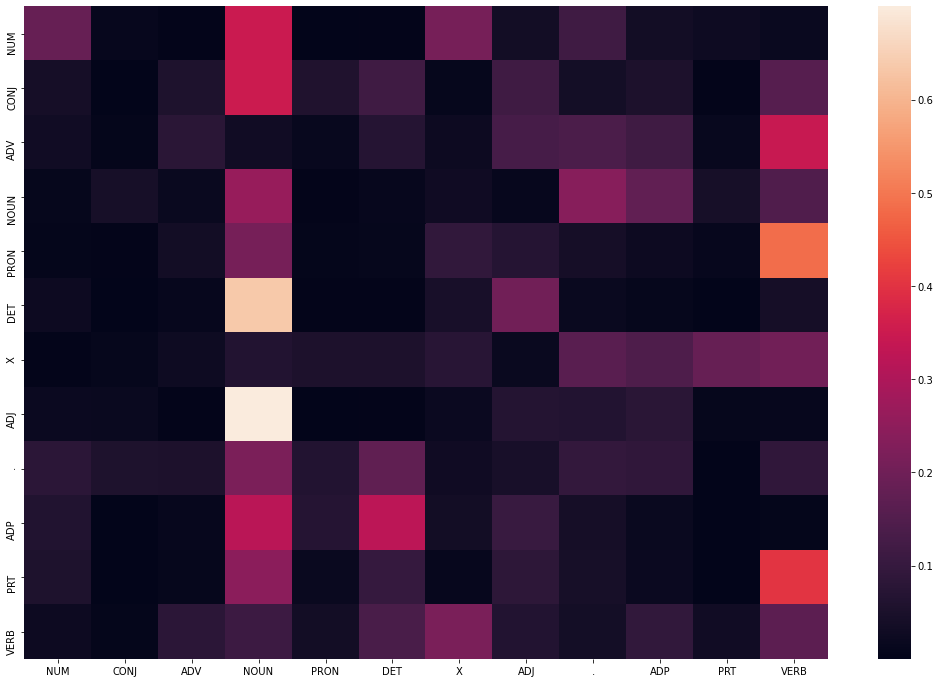

In [47]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

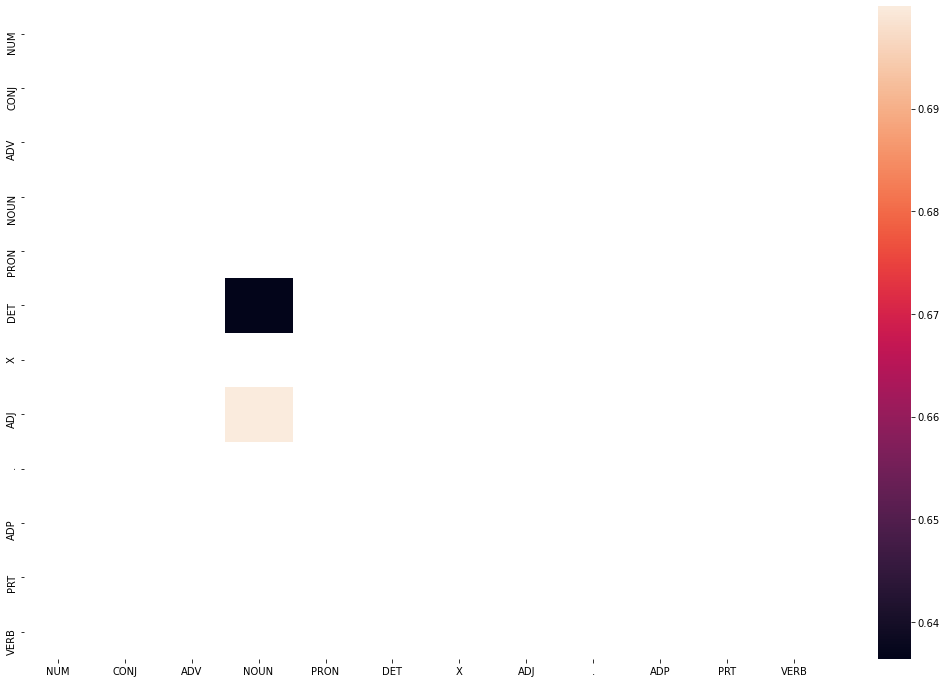

In [48]:
# frequent tags
# filter the df to get P(t2, t1) > 0.5
tags_frequent = tags_df[tags_df>0.5]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

In [84]:
import functools
import time
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        start = time.time()
        value = func(*args, **kwargs)
        print(f'{func.__name__} processsing finished in {time.time()-start} seconds')
        return value 
    wrapper_timer._original = func
    return wrapper_timer

# Viterbi Heuristic
@timer
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [65]:
# Running on entire test dataset would take more than 3-4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Such', 'ADJ'),
  ('multi-crystal', 'ADJ'),
  ('materials', 'NOUN'),
  ('will', 'VERB'),
  ('probably', 'ADV'),
  ('be', 'VERB'),
  ('needed', 'VERB'),
  ('*-1', 'X'),
  ('for', 'ADP'),
  ('commercial', 'ADJ'),
  ('applications', 'NOUN'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Spiegel', 'NOUN'),
  ("'s", 'PRT'),
  ('fans', 'NOUN'),
  ('say', 'VERB'),
  ('0', 'X'),
  ('Columbia', 'NOUN'),
  ("'s", 'PRT'),
  ('Southern', 'NOUN'),
  ('California', 'NOUN'),
  ('branches', 'NOUN'),
  ('are', 'VERB'),
  ('highly', 'ADV'),
  ('salable', 'ADJ'),
  (',', '.'),
  ('and', 'CONJ'),
  ('the', 'DET'),
  ('thrift', 'NOUN'),
  ('has', 'VERB'),
  ('$', '.'),
  ('458', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('of', 'ADP'),
  ('shareholders', 'NOUN'),
  ('equity', 'NOUN'),
  ('underlying', 'VERB'),
  ('its', 'PRON'),
  ('assets', 'NOUN'),
  ('.', '.')],
 [('Dealers', 'NOUN'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('U.K.', 'NOUN'),
  ('government', 'NOUN'),
  ("'s", 'PRT'),
  ('d

In [66]:
# tagging the test sentences
tagged_seq = Viterbi(test_tagged_words)


Viterbi processsing finished in 23.720897912979126 seconds


In [67]:
tagged_seq[:10]

[('Such', 'ADJ'),
 ('multi-crystal', 'ADJ'),
 ('materials', 'NOUN'),
 ('will', 'VERB'),
 ('probably', 'ADV'),
 ('be', 'VERB'),
 ('needed', 'VERB'),
 ('*-1', 'X'),
 ('for', 'ADP'),
 ('commercial', 'ADJ')]

In [68]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
print(f'Accuracy using Vanilla Viterbi Algorithm on Test Set: {len(check)/len(tagged_seq)}')

Accuracy using Vanilla Viterbi Algorithm on Test Set: 0.9285714285714286


In [69]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('highly', 'ADV'), (('salable', 'NUM'), ('salable', 'ADJ'))],
 [('to', 'PRT'), (('waive', 'NUM'), ('waive', 'VERB'))],
 [('its', 'PRON'), (('protective', 'NUM'), ('protective', 'ADJ'))],
 [('``', '.'), (('golden', 'NUM'), ('golden', 'ADJ'))],
 [('Jay', 'NOUN'), (('Goldinger', 'NUM'), ('Goldinger', 'NOUN'))],
 [('Capital', 'NOUN'), (('Insight', 'NUM'), ('Insight', 'NOUN'))],
 [(',', '.'), (('reasons', 'NOUN'), ('reasons', 'VERB'))],
 [('yen', 'NOUN'), (('as', 'ADP'), ('as', 'ADV'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('--', '.'), (('the', 'DET'), ('the', 'ADJ'))],
 [('*-1', 'X'), (('lure', 'VERB'), ('lure', 'NOUN'))],
 [('London', 'NOUN'), (('borough', 'NUM'), ('borough', 'NOUN'))]]

In [70]:

wrong_tagged_words = [j[0][0] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]
wrong_tagged_words

['salable',
 'waive',
 'protective',
 'golden',
 'Goldinger',
 'Insight',
 'reasons',
 'as',
 'the',
 'the',
 'lure',
 'borough']

## Test Sentences

In [97]:
# load test sentences
test_sentences_df = pd.read_csv('https://cdn.upgrad.com/UpGrad/temp/9dca5f3b-53c3-47e1-86d5-5ec5dafad6f0/Test_sentences.txt',header=None, delimiter='\n',names=  ['sentences'])
test_sentences_df

,sentences
0,Android is a mobile operating system developed...
1,Android has been the best-selling OS worldwide...
2,Google and Twitter made a deal in 2015 that ga...
3,Twitter is an online news and social networkin...
4,"Before entering politics, Donald Trump was a d..."
5,The 2018 FIFA World Cup is the 21st FIFA World...
6,This is the first World Cup to be held in East...
7,Show me the cheapest round trips from Dallas t...
8,I would like to see flights from Denver to Phi...
9,Show me the price of the flights leaving Atlan...


In [100]:
test_sentences_df['tokenized'] = test_sentences_df.sentences.apply(nltk.word_tokenize)

In [101]:
test_sentences_df['tagged'] = test_sentences_df.tokenized.apply(Viterbi._original)

In [102]:
test_sentences_df

,sentences,tokenized,tagged
0,Android is a mobile operating system developed...,"[Android, is, a, mobile, operating, system, de...","[(Android, NUM), (is, VERB), (a, DET), (mobile..."
1,Android has been the best-selling OS worldwide...,"[Android, has, been, the, best-selling, OS, wo...","[(Android, NUM), (has, VERB), (been, VERB), (t..."
2,Google and Twitter made a deal in 2015 that ga...,"[Google, and, Twitter, made, a, deal, in, 2015...","[(Google, NUM), (and, CONJ), (Twitter, NUM), (..."
3,Twitter is an online news and social networkin...,"[Twitter, is, an, online, news, and, social, n...","[(Twitter, NUM), (is, VERB), (an, DET), (onlin..."
4,"Before entering politics, Donald Trump was a d...","[Before, entering, politics, ,, Donald, Trump,...","[(Before, ADP), (entering, VERB), (politics, N..."
5,The 2018 FIFA World Cup is the 21st FIFA World...,"[The, 2018, FIFA, World, Cup, is, the, 21st, F...","[(The, DET), (2018, NUM), (FIFA, NUM), (World,..."
6,This is the first World Cup to be held in East...,"[This, is, the, first, World, Cup, to, be, hel...","[(This, DET), (is, VERB), (the, DET), (first, ..."
7,Show me the cheapest round trips from Dallas t...,"[Show, me, the, cheapest, round, trips, from, ...","[(Show, NOUN), (me, PRON), (the, DET), (cheape..."
8,I would like to see flights from Denver to Phi...,"[I, would, like, to, see, flights, from, Denve...","[(I, PRON), (would, VERB), (like, ADP), (to, P..."
9,Show me the price of the flights leaving Atlan...,"[Show, me, the, price, of, the, flights, leavi...","[(Show, NOUN), (me, PRON), (the, DET), (price,..."


In [115]:
# count of words vs tags from test file
test_words = set([word for word in test_sentences_df.tokenized] )
# word_tag_count = [(word, tag, word_given_tag(word, tag)[0]) for word in test_words for tag in tags]
# word_tag_count_df = pd.DataFrame.from_records(word_tag_count, columns=['word','tag','count'])
# word_tag_count_df = word_tag_count_df.pivot(index='word', columns='tag', values=['count']).reset_index()
# word_tag_count_df.columns = [col[1] if col[0] != 'word' else col[0] for col in word_tag_count_df.columns.values]
# word_tag_count_df

TypeError: unhashable type: 'list'

In [114]:
test_words

{' ',
 "'",
 ',',
 '-',
 '.',
 '0',
 '1',
 '2',
 '3',
 '5',
 '8',
 'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'I',
 'N',
 'O',
 'P',
 'S',
 'T',
 'W',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y'}

https://nbviewer.jupyter.org/github/keensam04/upgrad_pgdmlai/blob/master/HMM-based_POS_tagger/Syntactic_Analysis_Assignment.ipynb

https://github.com/iamurali/upgrad_ml_ai/blob/master/NLP/HMM%2B-based%2BPOS%2Btagging-%2BAssignment.ipynb

### Solve the problem of unknown words

#### Evaluating tagging accuracy

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications